# 概要
- 冷蔵庫の写真を人気して説明
- そこから作れる料理をLLMが推測
- その料理を食べることができる店を検索（GCPの[Places API](https://developers.google.com/maps/documentation/places/web-service/text-search?hl=ja)）

In [1]:
from configs import const
from src import functions
from openai import OpenAI
import base64
import requests
import os
import re
import pandas as pd
from IPython.display import Image
from langchain_openai import OpenAI, ChatOpenAI
from langchain import PromptTemplate, LLMChain

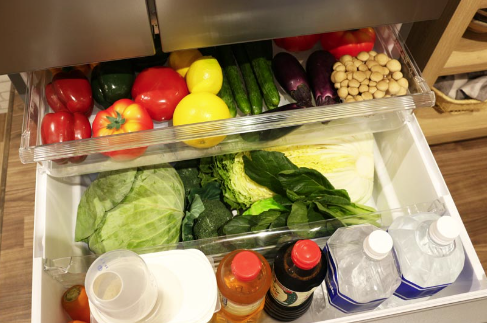

In [2]:
# 画像ファイル名(パス)
image_path = const.DATA_PATH + "images/vegetables.png"

# IPythonで画像の読み込みと表示
Image(image_path)

In [5]:
# Getting the base64 string
base64_image = functions.encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}"
}

prompt="""
この画像について教えてください。
"""

payload = {
  "model": "gpt-4o",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json()["choices"][0]["message"]["content"])

この画像は、冷蔵庫の野菜室（野菜を保存するための引き出し部分）を開けた状態を示しています。引き出しの中には様々な野菜と瓶やボトルが入っています。

上段には色鮮やかなパプリカやトマト、キュウリ、ナス、そしておそらくシイタケが見えます。下段にはキャベツや白菜、ほうれん草と思われる葉野菜があります。また、右側にはペットボトルに入った水や調味料（おそらくソースや酢）が置かれています。

この冷蔵室は整理整頓されており、各アイテムが取り出しやすく配置されていることがわかります。


In [10]:
llm = ChatOpenAI(api_key=os.environ['OPENAI_API_KEY'], model_name="gpt-4o", max_tokens=1500) 

# プロンプトテンプレートの作成
prompt_template = PromptTemplate(
    input_variables=["description"],
    template="""
    材料情報を参考にどんな料理ができるか推測してください。
    その後回答形式に従って回答を出力してください。
    
    # 材料情報
    {description}

    # 回答形式
    料理名：[ここに料理名]
    """
)

# LLMChainの作成
llm_chain = LLMChain(prompt=prompt_template, llm=llm)

# 回答を生成
result = llm_chain.run(description=response.json()["choices"][0]["message"]["content"])
print(result)
dish_name = re.search(r'料理名：(.+)', result).group(1)
print(dish_name)

料理名：野菜たっぷりのラタトゥイユ
野菜たっぷりのラタトゥイユ


In [8]:
dish_name = re.search(r'料理名：(.+)', result).group(1)
dish_name

'野菜スープ'

In [11]:
# パラメータの設定
params = {
    'key': const.GOOGLE_API_KEY,
    'query': dish_name,  # 検索キーワード
    'language': 'ja'  # 日本語での結果を取得
}

# APIリクエストの送信
response = requests.get(const.PLACES_API_ENDPOINT, params=params)

In [12]:
# レスポンスの処理
if response.status_code == 200:
    data = response.json()
    if data['status'] == 'OK':
        results = []
        for place in data['results']:
            name = place['name']
            address = place.get('formatted_address', '住所情報なし')
            rating = place.get('rating', '評価なし')
            user_ratings_total = place.get('user_ratings_total', '評価数なし')
            opening_hours = place.get('opening_hours', '営業時間なし')
            geometry = place.get('geometry', '位置情報なし')
            results.append({
                '店名': name,
                '住所': address,
                '評価': rating,
                '評価合計': user_ratings_total,
                '営業時間': opening_hours,
                '位置情報': geometry
            })
        
        # データフレームに変換
        df = pd.DataFrame(results)
        df = df.sort_values(by='評価', ascending=False)
        display(df)
    else:
        print(f"APIリクエストが失敗しました。ステータス: {data['status']}, エラーメッセージ: {data.get('error_message', 'なし')}")
else:
    print(f"HTTPリクエストが失敗しました。ステータスコード: {response.status_code}")

,店名,住所,評価,評価合計,営業時間,位置情報
6,ぶたとやさい,日本、〒153-0041 東京都目黒区駒場２丁目１−３,5.0,12,{'open_now': False},"{'location': {'lat': 35.6586052, 'lng': 139.68..."
10,la toile トワル,日本、〒155-0032 東京都世田谷区代沢２丁目４５−９ 飛田ビル１０１,4.7,22,{'open_now': False},"{'location': {'lat': 35.6607433, 'lng': 139.67..."
3,Tudore Tranquility,日本、〒151-0064 東京都渋谷区上原２丁目６−１６,4.7,43,{'open_now': False},"{'location': {'lat': 35.666702, 'lng': 139.683..."
16,セット エ ユイット,日本、〒156-0051 東京都世田谷区宮坂１丁目２１−２０,4.7,91,{'open_now': False},"{'location': {'lat': 35.6480659, 'lng': 139.64..."
2,ラタトゥイユ,日本、〒231-0013 神奈川県横浜市中区住吉町３丁目３７,4.6,65,{'open_now': False},"{'location': {'lat': 35.446449, 'lng': 139.636..."
9,THE TAMUYA,日本、〒153-0043 東京都目黒区東山１丁目１１−１５,4.5,22,{'open_now': False},"{'location': {'lat': 35.6482463, 'lng': 139.69..."
0,WINE & FRENCH a La Bouteille (ア ラ ブテイユ),日本、〒160-0004 東京都新宿区四谷１丁目８−１４ 四谷一丁目ビル B1,4.5,56,{'open_now': True},"{'location': {'lat': 35.6863499, 'lng': 139.72..."
1,ラチュレ,日本、〒150-0002 東京都渋谷区渋谷２丁目２−２ 青山ルカビル 地下１階,4.4,516,{'open_now': False},"{'location': {'lat': 35.660762, 'lng': 139.708..."
19,ブノワ 東京,日本、〒150-0001 東京都渋谷区神宮前５丁目５１−８ ラ・ポルト青山 10F,4.4,533,{'open_now': False},"{'location': {'lat': 35.66282959999999, 'lng':..."
8,ラ·グラティチュード,日本、〒162-0805 東京都新宿区矢来町５７−２,4.3,50,{'open_now': False},"{'location': {'lat': 35.7039953, 'lng': 139.73..."


In [ ]:
# パラメータの設定
params = {
    'key': const.GOOGLE_API_KEY,
    'query': dish_name,  # 検索キーワード
    'language': 'ja'  # 日本語での結果を取得
}

# APIリクエストの送信
response = requests.get(const.PLACES_API_ENDPOINT, params=params)
# レスポンスの処理
if response.status_code == 200:
    data = response.json()
    if data['status'] == 'OK':
        results = []
        for place in data['results']:
            name = place['name']
            address = place.get('formatted_address', '住所情報なし')
            rating = place.get('rating', '評価なし')
            user_ratings_total = place.get('user_ratings_total', '評価数なし')
            opening_hours = place.get('opening_hours', '営業時間なし')
            geometry = place.get('geometry', '位置情報なし')
            results.append({
                '店名': name,
                '住所': address,
                '評価': rating,
                '評価合計': user_ratings_total,
                '営業時間': opening_hours,
                '位置情報': geometry
            })
        
        # データフレームに変換
        df = pd.DataFrame(results)
        df = df.sort_values(by='評価', ascending=False)
        display(df)
    else:
        print(f"APIリクエストが失敗しました。ステータス: {data['status']}, エラーメッセージ: {data.get('error_message', 'なし')}")
else:
    print(f"HTTPリクエストが失敗しました。ステータスコード: {response.status_code}")